**1. Dataset Loading**

In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the beans dataset
(ds_train, ds_test), ds_info = tfds.load('beans', split=['train', 'test'], as_supervised=True, with_info=True)

# Display dataset information
print(ds_info)

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_dir='/root/tensorflow_datasets/beans/0.1.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        'train': <Spl

**2. Data Visualization**

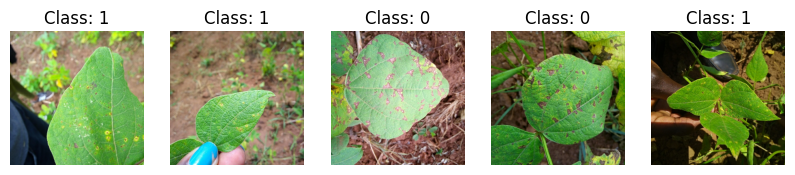

In [24]:
import matplotlib.pyplot as plt

# Function to visualize images and labels
def visualize_data(dataset, num_images=5):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        # Instead of decoding, directly use the label
        plt.title(f'Class: {label.numpy()}')  # Show label as an integer
        plt.axis("off")
    plt.show()

# Visualize training data
visualize_data(ds_train)

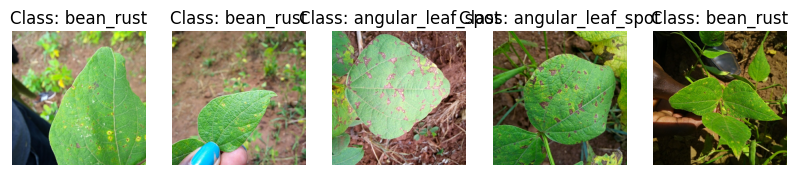

In [25]:
# Assuming ds_info contains class names in a dictionary format
class_names = ds_info.features['label'].names  # Get class names if available

# Update visualization function to show class names
def visualize_data_with_names(dataset, num_images=5):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        # Use class name instead of integer label
        plt.title(f'Class: {class_names[label.numpy()]}')  # Show label as a name
        plt.axis("off")
    plt.show()

# Visualize training data with class names
visualize_data_with_names(ds_train)

**3. Data Preprocessing**

In [26]:
IMG_SIZE = 224  # MobileNetV2 input size

def preprocess_image(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize images to match model input
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

# Apply preprocessing to the datasets
ds_train = ds_train.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

**4. Model Setup for Transfer Learning**

In [27]:
from tensorflow.keras import layers, models

# Load the MobileNetV2 model with pre-trained weights
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation='softmax')  # Assuming 10 classes in the beans dataset
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


**5. Training the Model**

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(ds_train,
                    validation_data=ds_test,
                    epochs=10,
                    callbacks=[early_stopping])

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.4870 - loss: 1.1865 - val_accuracy: 0.7734 - val_loss: 0.5363
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8151 - loss: 0.4694 - val_accuracy: 0.8359 - val_loss: 0.4157
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8657 - loss: 0.3450 - val_accuracy: 0.8594 - val_loss: 0.3655
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9009 - loss: 0.2822 - val_accuracy: 0.8672 - val_loss: 0.3334
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9270 - loss: 0.2411 - val_accuracy: 0.8672 - val_loss: 0.3112
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9377 - loss: 0.2113 - val_accuracy: 0.8672 - val_loss: 0.2950
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9488 - loss: 0.1886 - val_accuracy: 0.8828 - val_loss: 0.2825
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9542 - loss: 0.1705 - val_accuracy: 0.8984 - val_loss:

**6. Model Evaluation**

In [29]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(ds_test)
print(f'Test Accuracy: {accuracy:.2f}')

# You can also calculate precision and recall using sklearn if needed.
from sklearn.metrics import classification_report

y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

print(classification_report(y_true, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9115 - loss: 0.2736
Test Accuracy: 0.91
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        43
           1       0.90      0.84      0.87        43
           2       0.98      0.95      0.96        42

    accuracy                           0.91       128
   macro avg       0.92      0.91      0.91       128
weighted avg       0.92      0.91      0.91       128



**7. Model Saving and Reusability**

In [30]:
# Save the trained model in Keras format
model.save('bean_classifier.keras')

# To load the model later:
loaded_model = tf.keras.models.load_model('bean_classifier.keras')

**8. Deploying a Streamlit Application**

In [31]:
pip install streamlit pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.7 MB/s eta 0:00:00


In [32]:
import streamlit as st
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

# Load the trained model
model = load_model('bean_classifier.keras')

def preprocess_image(image):
    image = image.resize((224, 224))  # Resize to match model input size
    image_array = np.array(image) / 255.0  # Normalize to [0, 1]
    return np.expand_dims(image_array, axis=0)  # Add batch dimension

st.title("Bean Disease Classification")
st.write("Upload an image of a bean to classify its disease.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image.', use_column_width=True)

    processed_image = preprocess_image(image)

    predictions = model.predict(processed_image)
    predicted_class = np.argmax(predictions[0])

    st.write(f"Predicted Class: {predicted_class}")

2024-11-20 09:21:35.036 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-20 09:21:35.171 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-11-20 09:21:35.172 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-20 09:21:35.176 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-20 09:21:35.178 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-20 09:21:35.181 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-20 09:21:35.184 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-20 09:21:35.186 Thread 'MainThread': mi

In [ ]:
streamlit run app.py # To run the above interface